# Sabermetrics
## Creating The Perfect Team
Using the median salary from players create the ideal team to win games and predict how many games the newly formed team will win. I will be using the Sean Lahman's Baseball Database. From this database, I will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import seaborn as sns
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Read a zipfile from http://www.seanlahman.com/baseball-archive/statistics/ with the module requests, stringify the file and open the zipfile 

In [2]:
import requests
from StringIO import StringIO
from zipfile import ZipFile

url = 'http://seanlahman.com/files/database/lahman-csv_2015-01-24.zip'

r = requests.get(url).content
s = StringIO(r)
zf = ZipFile(s)

Create a function to open all file and read it into a pandas dataframe

In [3]:
csv_files = zf.namelist()

def unzip_file(filename):
    return pd.read_csv(zf.open(csv_files[csv_files.index(filename)]))


Assign five panda data frames to their respective names and print the head of the salary data frame

In [4]:
teams = unzip_file('Teams.csv')
salaries = unzip_file('Salaries.csv')
players = unzip_file('Batting.csv')
fielding = unzip_file('Fielding.csv')
master = unzip_file('Master.csv')

In [5]:
salaries.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


New data frame containing the median salary for each player with the included the player ID, the first name of the player, the last name of the player and the median salary of the player. I use the median salary insead of the the mean salary for each player because the data for these players are not normally distributed and is skewed, so the median is the better estimate for this alanysis

In [6]:
# combine all by playerIDs, take the median of salary and subset desired coluns
salary_group = salaries.groupby('playerID', as_index = False).median()[['playerID', 'salary']]
# merge the master data frame with the created median salary grouping and pluck out desired columns
medianSalaries = pd.merge(salary_group, master, on = 'playerID', how = 'inner')[['playerID', 'nameFirst', 'nameLast', 'salary']]

In [7]:
medianSalaries.head()

,playerID,nameFirst,nameLast,salary
0,aardsda01,David,Aardsma,419000
1,aasedo01,Don,Aase,612500
2,abadan01,Andy,Abad,327000
3,abadfe01,Fernando,Abad,485000
4,abbotje01,Jeff,Abbott,255000


Subset the data to only include seasons in which the teams played 162 games and seasons after 1947 for a better estimate of the newer population. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB.

In [8]:
# subset data
sub_teams = teams[(teams.G == 162) & (teams.yearID > 1947)].copy()

# since HBP wasn't recorded until later we need to address issue
print 'There are {}, missing valuses for HBP'.format(np.sum(sub_teams.HBP.isnull()))

# fill these NA with 0 as it won't change data
sub_teams.HBP.fillna(0, inplace = True)

# add plate appearances to dataframe, hits + walks + hit by pitch
sub_teams['PA'] = sub_teams.H + sub_teams.BB + sub_teams.HBP
# add singles to dataframe
sub_teams['1B'] = sub_teams.H - sub_teams['2B'] - sub_teams['3B'] - sub_teams['HR']

# create new per plate appearances columns
for col in ['1B', '2B', '3B', 'HR', 'BB']:
    sub_teams[col + '_rate'] = sub_teams[col] / sub_teams.PA
team_stats = sub_teams[['teamID', 'yearID', 'W', '1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']]

There are 610, missing valuses for HBP


In [9]:
team_stats.head()

,teamID,yearID,W,1B_rate,2B_rate,3B_rate,HR_rate,BB_rate
1366,KC1,1961,61,0.514568,0.112383,0.024454,0.046826,0.301769
1367,LAA,1961,70,0.448310,0.108350,0.010934,0.093936,0.338469
1377,BAL,1962,77,0.504524,0.119745,0.018095,0.083023,0.274614
1379,CHA,1962,85,0.499754,0.122850,0.027518,0.045209,0.304668
1380,CHN,1962,59,0.536278,0.103049,0.029443,0.066246,0.264984


Investigate these rates in regards to time. Plot years vs rates. I also included a prelimalary regression line to get a quick estimate of the distribution

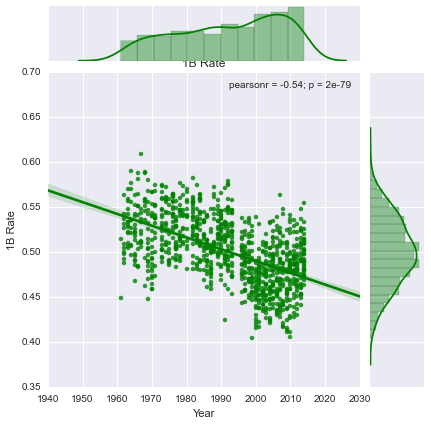

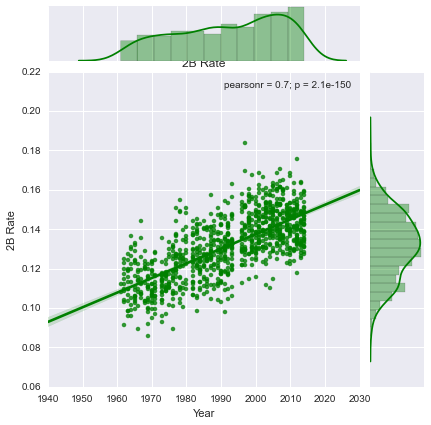

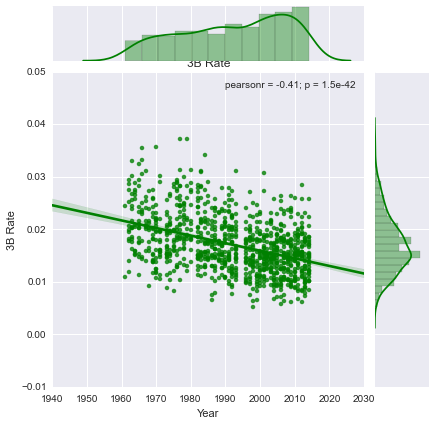

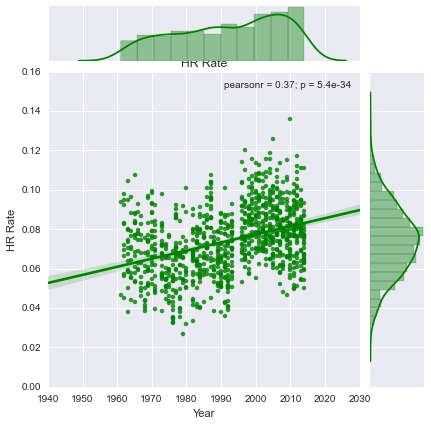

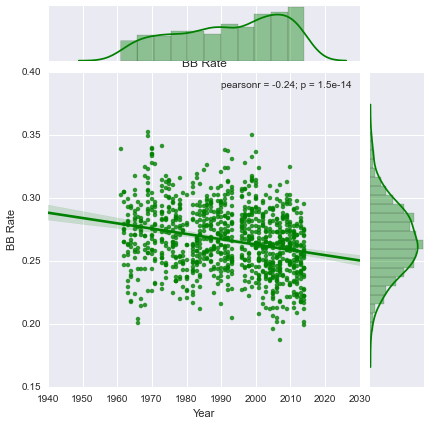

In [10]:
for col in ['1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']:
    sns.jointplot('yearID', col, data = team_stats, kind = 'reg', color = 'g')
    plt.title(col[0:2] + ' Rate')
    plt.xlabel('Year')
    plt.ylabel(col[0:2] + ' Rate')

Mean normalize the data. Adjust the columns per plate appearance so that the average across teams for each year is 0. I create a function to do just this

In [11]:
def meanNormalizeRates(df):
    rates = df[['1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']]
    df[['1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']] = rates - rates.mean(axis = 0)
    return df

team_stats = team_stats.groupby('yearID').apply(meanNormalizeRates)
team_stats.head()

,teamID,yearID,W,1B_rate,2B_rate,3B_rate,HR_rate,BB_rate
1366,KC1,1961,61,0.033129,0.002017,0.006760,-0.023555,-0.018350
1367,LAA,1961,70,-0.033129,-0.002017,-0.006760,0.023555,0.018350
1377,BAL,1962,77,-0.012365,0.008083,-0.003027,0.008735,-0.001426
1379,CHA,1962,85,-0.017134,0.011188,0.006397,-0.029079,0.028628
1380,CHN,1962,59,0.019389,-0.008612,0.008321,-0.008042,-0.011056


Simple linear regression to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. I will use this  model to define a new sabermetric feature - Predicted Wins (PW).

I will use sklearns train/test split and I will use the Compute the mean squared error for this fitted model

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

# predictor variables 
feature_columns = ['1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']

# train test split
X_train, X_test, y_train, y_test = train_test_split(team_stats[feature_columns], 
                                                    team_stats['W'], test_size = 0.25, random_state = 100)
# initialize linear regression
lm = LinearRegression()
# fit training set
lm.fit(X_train, y_train)
# show coefficients
zip(feature_columns, lm.coef_)

[('1B_rate', -13.539353435661972),
 ('2B_rate', 37.236560223094209),
 ('3B_rate', 165.67830551826663),
 ('HR_rate', 180.35913100337655),
 ('BB_rate', 96.309953004836174)]

The lowest mean squared error with any combination of the feature variables was the model with all the variabels included

In [13]:
# predict on the testing set
pred = lm.predict(X_test)
# compute RSS
RSS = np.mean((pred - y_test)**2)
print 'The mean squared error is %.2f' %(RSS)

The mean squared error is 122.76


I will now do a similiar thing to the player dataframe, by first subseting the players frame to only include players with atleast 500 plate appearances and after the 1947 again. I will again compute the singles, doubles, triples, HR, BB per plate appearance rates

In [14]:
# fill both HBP and IBB with 0 where they result in NA
players.HBP.fillna(0, inplace = True)
players.IBB.fillna(0, inplace = True)
# subset players on copy of data
sub_players = players[(players.AB + players.BB >= 500) & (players.yearID > 1947)].copy()

sub_players['PA'] = sub_players.H + sub_players.BB + sub_players.HBP
sub_players['1B'] = sub_players.H - sub_players['2B'] - sub_players['3B'] - sub_players['HR']

for col in ['1B', '2B', '3B', 'HR', 'BB']:
    sub_players[col + '_rate'] = sub_players[col] / sub_players.PA
player_stats = sub_players[['playerID', 'yearID', '1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']]

In [15]:
player_stats.groupby('yearID').apply(meanNormalizeRates)
player_stats.head()

,playerID,yearID,1B_rate,2B_rate,3B_rate,HR_rate,BB_rate
33320,applilu01,1948,0.552000,0.064000,0.008000,0.000000,0.376000
33322,ashburi01,1948,0.609302,0.079070,0.018605,0.009302,0.279070
33358,boudrlo01,1948,0.471572,0.113712,0.020067,0.060201,0.327759
33384,chapmsa01,1948,0.456140,0.105263,0.035088,0.076023,0.321637
33391,coangi01,1948,0.538922,0.077844,0.053892,0.041916,0.245509



Create function to calculate the lifetime stats for each player and pluck out the year from the start and end game for their career. Get the average lifetime statistics (1B, 2B, 3B, HR and BB) for each player.  

In [16]:
def lifetimeStats(df):
    df = df[['playerID', '1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']].mean()
    return df

In [17]:
def get_year(x):
    return int(x[-4:])

group by playerID to compute lifetime stats and reset index

In [18]:
player_lifetime_stats = player_stats.groupby('playerID').apply(lifetimeStats)
# reset index, not to use playerID as index and not use misc numbers
player_lifetime_stats = player_lifetime_stats.reset_index()

Merge the master dataframe with debut and finalGame with the new data frame just created

In [19]:
sub_master = master[['playerID', 'debut', 'finalGame']]

player_lifetime_stats = pd.merge(sub_master, player_lifetime_stats, on = 'playerID')

Apply the get_year function to return the year of the first and last game played for that player

In [20]:
# pluck out year
player_lifetime_stats['debut'] = player_lifetime_stats.debut.apply(get_year)
player_lifetime_stats['finalGame'] = player_lifetime_stats.finalGame.apply(get_year)

# set new column names
cols = list(player_lifetime_stats.columns)
cols[1:3] = ['debutYear', 'finalYear']
player_lifetime_stats.columns = cols

Now use the prediction model that we created previously to add a new column to the `player_lifetime_stats` dataframe for the players Predicted Wins

In [21]:
player_avg = player_lifetime_stats[['1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']].values

player_lifetime_stats['PW'] = lm.predict(player_avg)

In [22]:
player_lifetime_stats.head()

,playerID,debutYear,finalYear,1B_rate,2B_rate,3B_rate,HR_rate,BB_rate,PW
0,aaronha01,1954,1976,0.440640,0.119938,0.019427,0.144185,0.269768,134.672075
1,abramca01,1949,1956,0.521505,0.053763,0.032258,0.080645,0.311828,125.829826
2,abreubo01,1996,2014,0.390708,0.144851,0.015337,0.075654,0.365393,132.447658
3,abreujo02,2014,2014,0.432773,0.147059,0.008403,0.151261,0.214286,129.894829
4,ackledu01,2011,2014,0.504489,0.141565,0.017760,0.074916,0.251776,120.110801


Using another data frame loaded in previously, `fielding`, add new columns to `player_lifetime_stats` that includes the position of each player, first name, last name, and median salary

In [23]:
from collections import defaultdict

def add_positon(df):
    positions = df.POS
    d = defaultdict(int)
    for pos in positions:
        d[pos] += 1
    result = max(d.iteritems(), key = lambda x: x[1])
    return result[0]

player_position = fielding.groupby('playerID').apply(add_positon)
# reset index
player_position = player_position.reset_index()
# rename column 
player_position = player_position.rename(columns = {0:'POS'})

Merge this new data frame with the `player_lifetime_stats` then again merge `player_lifetime_stats` with the medianSalary dataframe the we previously created for each player

In [24]:
player_lifetime_merged = pd.merge(player_position, player_lifetime_stats, on = 'playerID', how = 'inner')
player_lifetime_merged = pd.merge(player_lifetime_merged, medianSalaries, on = 'playerID', how = 'inner')

In [25]:
player_lifetime_merged.head()

,playerID,POS,debutYear,finalYear,1B_rate,2B_rate,3B_rate,HR_rate,BB_rate,PW,nameFirst,nameLast,salary
0,abreubo01,OF,1996,2014,0.390708,0.144851,0.015337,0.075654,0.365393,132.447658,Bobby,Abreu,9000000
1,abreujo02,1B,2014,2014,0.432773,0.147059,0.008403,0.151261,0.214286,129.894829,Jose,Abreu,7000000
2,ackledu01,1B,2011,2014,0.504489,0.141565,0.017760,0.074916,0.251776,120.110801,Dustin,Ackley,2100000
3,adamsma01,1B,2012,2014,0.541436,0.187845,0.027624,0.082873,0.143646,113.989247,Matt,Adams,503000
4,adamsru01,SS,2004,2009,0.471591,0.153409,0.028409,0.045455,0.284091,120.560102,Russ,Adams,329500


Now I will subset the data to include players that are active in 2013 and 2014 that have played for atleast 2 years

In [91]:
active_players = player_lifetime_merged[(player_lifetime_merged.debutYear <= 2010) & \
                                        (player_lifetime_merged.finalYear >= 2014) & \
                                       (player_lifetime_merged.finalYear - player_lifetime_merged.debutYear >= 2)]

Plot the relationship between the median salary of each player and the predicted number of wins

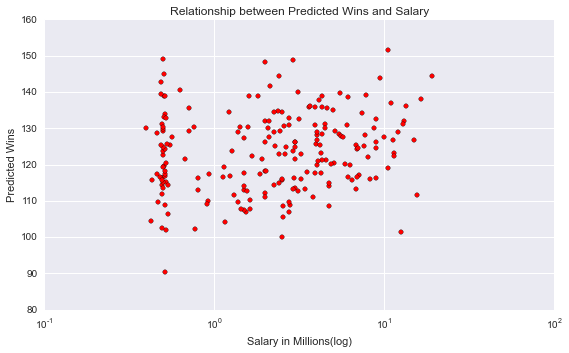

In [92]:
fig = plt.figure()
ax = fig.gca()

ax.scatter(active_players.salary / 1e6, active_players.PW, c = 'r')
ax.set_xscale('log')
ax.set_ylabel('Predicted Wins')
ax.set_xlabel('Salary in Millions(log)')
ax.set_title('Relationship between Predicted Wins and Salary')
plt.tight_layout()

Now we can get to the fun part, we have our data ready to actually predict our best players and create a team. Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary. we will crate our best team using the newly created column of predicted wins. 

In [93]:
s = salaries.groupby(['teamID', 'yearID'], as_index=False).sum()
s = s[s.yearID >= 2012]

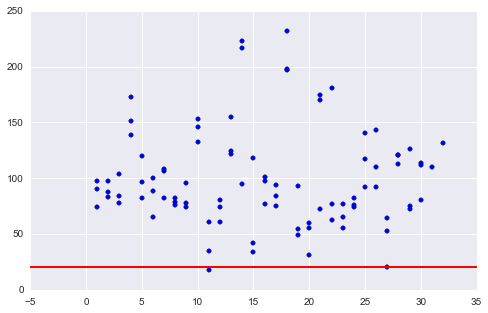

In [94]:
years = np.arange(2012, 2015)

for year in years:
    s3 = s[s.yearID == year]
    plt.scatter(np.arange(1,len(s3.salary)+1), s3.salary / 1e6)
    plt.axhline(y = 20, c = 'r')

First, we mean normalize the `OP` by position to compute a position specific residual

In [95]:
def meanNormalizePW(df):
    tmp = df[['resid']]
    df[['resid']] = tmp - tmp.median()
    return df

In [96]:
active_players['resid'] = active_players.PW
active_players = active_players.groupby('POS').apply(meanNormalizePW)

/Users/mattevanoff/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Next, fit a linear regression to calcualate the residuals

In [97]:
y = active_players.resid.values
X = np.log(active_players[['salary']])

lm = LinearRegression()
lm.fit(X, y)

active_players['resid'] = y - lm.predict(X)

In [98]:
active_players.head()

,playerID,POS,debutYear,finalYear,1B_rate,2B_rate,3B_rate,HR_rate,BB_rate,PW,nameFirst,nameLast,salary,resid
0,abreubo01,OF,1996,2014,0.390708,0.144851,0.015337,0.075654,0.365393,132.447658,Bobby,Abreu,9000000,4.564112
10,alonsyo01,1B,2010,2014,0.474419,0.181395,0.000000,0.041860,0.288372,116.621255,Yonder,Alonso,1120000,-13.777732
13,alvarpe01,3B,2010,2014,0.385856,0.127644,0.008183,0.179546,0.285094,141.691677,Pedro,Alvarez,2125000,17.775433
18,andruel01,SS,2009,2014,0.589712,0.108909,0.022068,0.016065,0.241313,106.832710,Elvis,Andrus,1538590,-8.314052
26,avilaal01,C,2009,2014,0.380282,0.154930,0.018779,0.089202,0.342723,133.794633,Alex,Avila,510000,15.209705


The resid columns contains about a half of the values as negitive residuals, we can eliminate them as they won't be on our team

In [99]:
active_players.POS.value_counts()

OF    77
SS    28
1B    26
3B    22
2B    22
C     18
LF    17
dtype: int64

In [143]:
# since we don't really care about negitive resids, we can eliminate them.
active_players = active_players[active_players.resid > 0]

We can then calculate the minimum salary for each position so we can make sure that we reserve that much money for each position and not go over our alloted cap

In [144]:
def calc_min_salary(salary):
    return np.min(salary['salary'])

In [145]:
minSalariesPos = active_players.groupby('POS').apply(calc_min_salary)
minSalariesPos.sort(ascending = False)

In [146]:
money_cap = 20 * 1e6

Now we can iterate through all the positions and draft our player that is the farthest from the norm in regards to deviations from the mean. Then subtract that from the salary_cap and make sure we keep enough to afford all players. Since we do not have a 'RF' column in our subsete dataframe we add another outfield position to play right field

In [147]:
idx = []

pos_left = list(minSalariesPos.index)
pos_left.append('OF')
print pos_left

for i in range(len(pos_left)):
    # this much money left
    max_money = money_cap - np.sum([minSalariesPos[x] for x in pos_left[:-1]])
    
    # consider only players we havent drafted yet
    index = [True if elem in pos_left else False for elem in active_players.POS.values]
    players_left = active_players[index & (active_players.salary <= max_money)]
    
    # draft the one that stands out the most
    player = players_left["resid"].argmax()
    idx.append(player)
    
    # remove drafted player
    pos_left.remove(players_left.loc[player].POS)
    money_cap = money_cap - players_left.loc[player].salary

['2B', 'C', '3B', 'SS', '1B', 'LF', 'OF', 'OF']


In [148]:
draft = active_players.loc[idx, :]
draft = draft.sort(['PW'], ascending = False)

Show the total salary for my team

In [149]:
draft['salary'].sum()

17897500.0

We can compute the expected number of wins with our wins. Since we are only predicting offensive players, we only have 8 players, and my drafted team will play in the National League, we need to add a pitcher to my team. For simplification we just add a 0 to the Predicted Offensive wins since pitchers do not add much to offensive presence

In [168]:
np.round((np.sum(draft['PW'])) / (len(draft['PW'])+ 1))

127.0

Create a function to convert singles, doubles, triples, home runs, and walk into real number again

In [120]:
def computeReal(player):
    return np.round(player * 1000)

Finally subset the data to display our drafted team and show the desired columns

In [122]:
draft[['1B', '2B', '3B' ,'HR', 'BB']] = draft[['1B_rate', '2B_rate', '3B_rate', 'HR_rate', 'BB_rate']].apply(computeReal)
draft[['PW']] = np.round(draft.PW)
draft[['nameFirst', 'nameLast', 'POS', '1B', '2B', '3B' ,'HR', 'BB', 'PW', 'salary', 'debutYear']]

,nameFirst,nameLast,POS,1B,2B,3B,HR,BB,PW,salary,debutYear
268,Adam,Dunn,OF,277,112,4,158,426,151,10500000,2001
157,Chris,Carter,1B,314,124,8,183,346,149,502000,2010
784,Mark,Reynolds,3B,297,128,7,163,374,148,2000000,2007
861,Giancarlo,Stanton,OF,325,132,14,153,350,145,508500,2010
819,Carlos,Santana,C,328,135,5,98,421,141,625950,2010
663,Logan,Morrison,LF,358,145,23,133,312,139,485750,2010
919,Luis,Valbuena,2B,355,177,22,86,349,136,712600,2008
1002,Ben,Zobrist,SS,400,147,19,69,352,131,2562700,2006
